<a href="https://colab.research.google.com/github/paarthbamb/dataScience/blob/main/Unit3/PaarBambU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **What's the Expected Spread of a Cowboys Game?**

# **Part I: Context**

In the world of sports betting, one of the most common metrics used to evaluate performance against expectations is the point spread. If a team has a negative spread, it means they are favored to win by the value of the spread. Likewise, if a team has a positive spread, it means the other team is favored to win by the value of the spread. I wanted to analyze how the Dallas Cowboys expected to perform by looking at the average spread value.



In [ ]:
!pip install preliz --quiet

import preliz as pz
import numpy as np
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats


**Data Collection**

I found a dataset of Cowboys games with their final scores and the betting spread.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/paarthbamb/nflData/refs/heads/main/nfl_cover_dataset.csv')
df


,date,opponent,cowboys_score,opponent_score,spread,cover
0,2016-09-11,Giants,27,26,-3.5,1
1,2016-09-18,Browns,20,10,-7.0,1
2,2016-09-25,Packers,16,35,+2.5,0
3,2016-10-02,Eagles,10,28,-4.5,0
4,2016-10-09,Steelers,24,26,+1.0,0
...,...,...,...,...,...,...
153,2024-12-08,49ers,17,35,+6.5,0
154,2024-12-15,Lions,33,27,-3.5,1
155,2024-12-22,Bears,21,10,-7.0,1
156,2024-12-29,Panthers,20,17,-3.0,1


Now I'll make a histogram to visualize this data:

(array([ 2.,  3., 10., 19., 27., 33., 10., 14., 29., 10.]),
 array([-17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,
          5. ,   7.5]),
 <BarContainer object of 10 artists>)

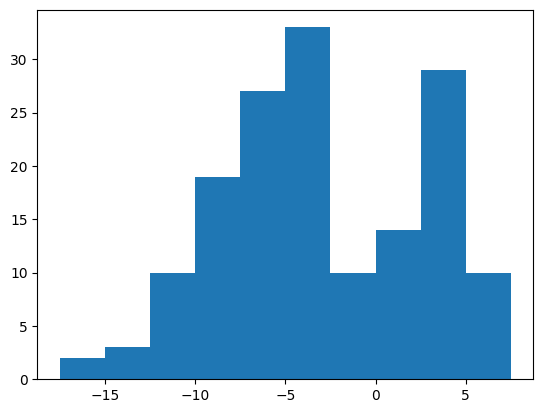

In [ ]:
data = pd.to_numeric(df['spread'], errors='coerce')
plt.hist(data)

From this histogram, we can see that the data is skewed left.

# **Part III: Priors**

First, we need a mean prior. My prior belief is that, since the Cowboys had a positive record for regular season games for quite a while (12-5 record for 2021, 2022, and 2023), the Cowboys should be expected a negative spread. But since I have no strong bias about whether they are predicted to win or lose, my prior will be weakly informative and centered at 0, using a Normal distribution with parameters μ = 0 and σ = 4.

<Axes: >

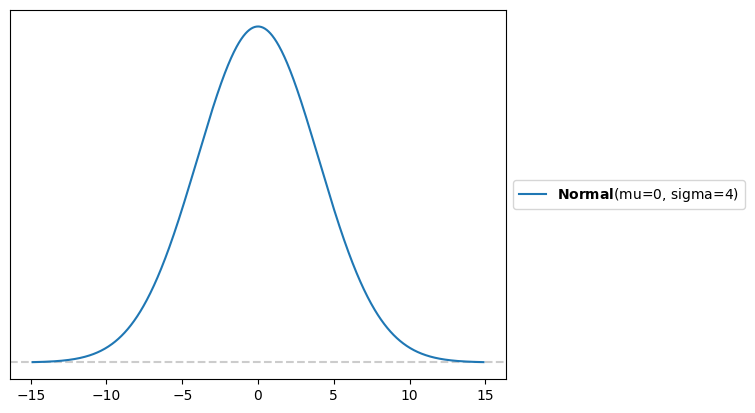

In [ ]:
pz.Normal(0,4).plot_pdf()

We also need a standard deviation prior, or a prior for how much the data varies around that mean. I haven't the foggiest, so I'm going to use a uniform distribution for this prior.

<Axes: >

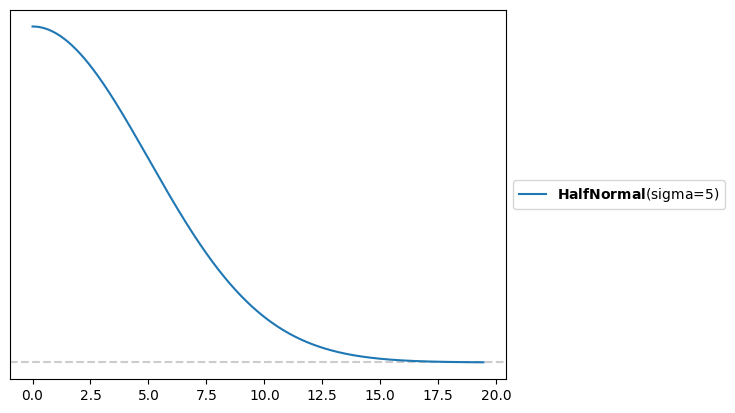

In [76]:
#standard deviation can't be negative and I have no idea what it is so I'm choosing 0 and 100 for the limits
pz.Uniform(0,100).plot_pdf()

# **Part IV: Initial Model**


In [ ]:
data_cleaned = data.dropna()
with pm.Model() as model_spread:
    # mean prior
    μ = pm.Normal('μ', sigma = 4)

    # standard deviation prior
    σ = pm.Uniform('σ', lower = 0, upper = 100)

    # likelihood
    y = pm.Normal('y', mu = μ, sigma = σ, observed = data_cleaned)

    idata_spread = pm.sample()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

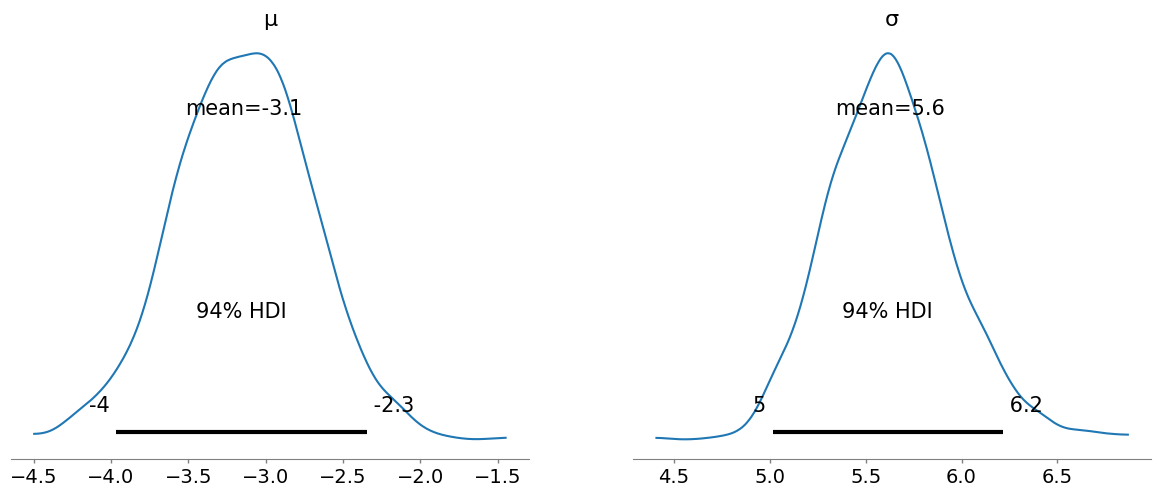

In [ ]:
az.plot_posterior(idata_spread)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

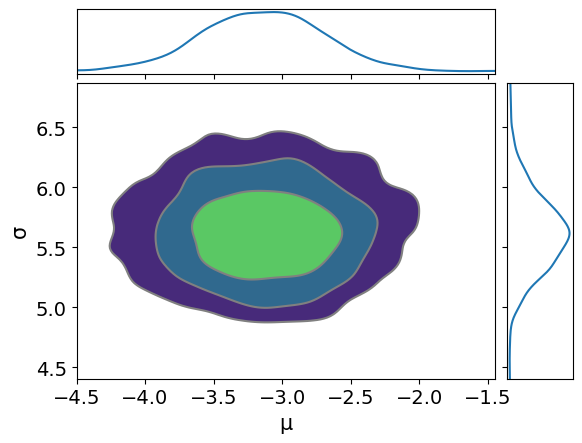

In [ ]:
az.plot_pair(idata_spread, kind='kde', marginals=True)

In [ ]:
pm.sample_posterior_predictive(idata_spread, model=model_spread, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(-25.0, 20.0)

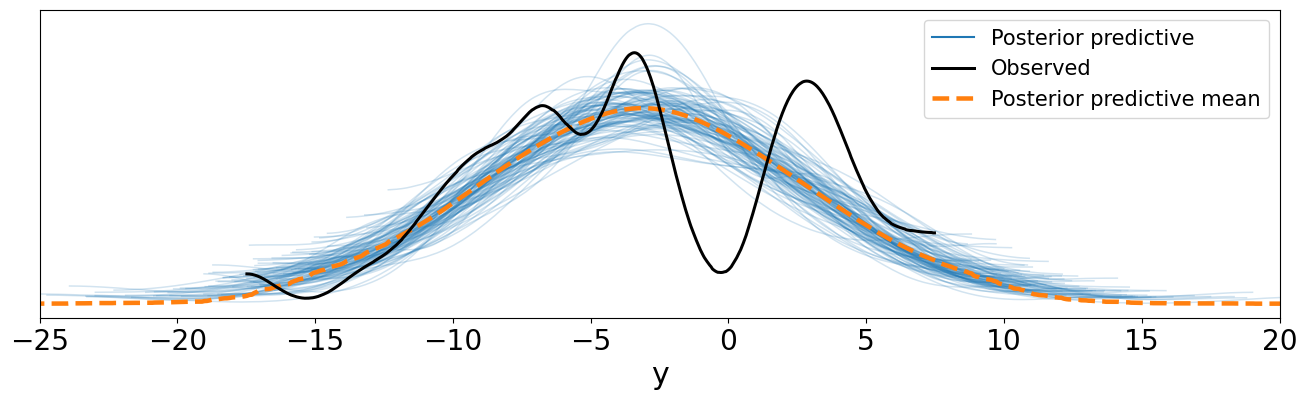

In [102]:
ax = az.plot_ppc(idata_spread, num_pp_samples=100, figsize=(16, 4))
ax.set_xlim(-25, 20)

The posterior predictive matches the observed for only about half the data. This is because this model doesn't take into account the volatility of the data, so I need to find a distribution that does to get a more accurate model.

# **Part V: Final Model & Conclusion**



**Priors:**

<Axes: >

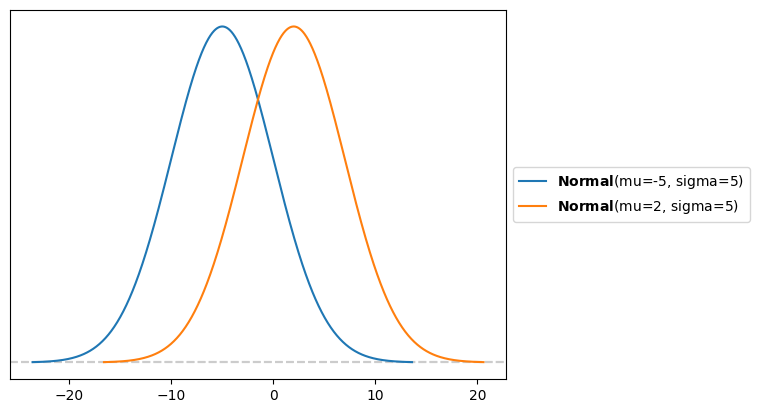

In [105]:
# mean priors
pz.Normal(-5, 5).plot_pdf()
pz.Normal(2, 5).plot_pdf()

<Axes: >

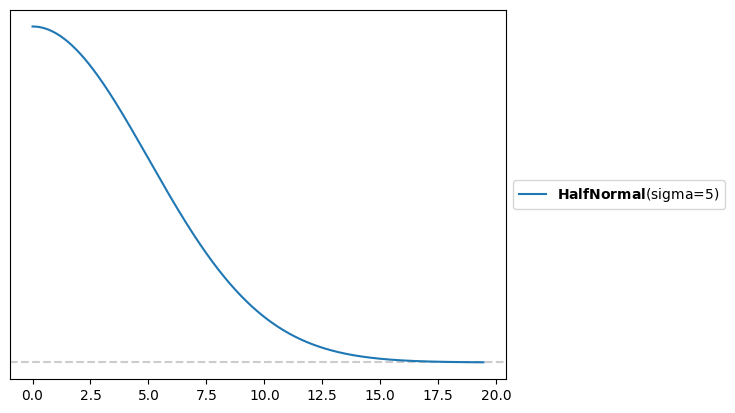

In [82]:
#standard deviation
pz.HalfNormal(5).plot_pdf()

<Axes: >

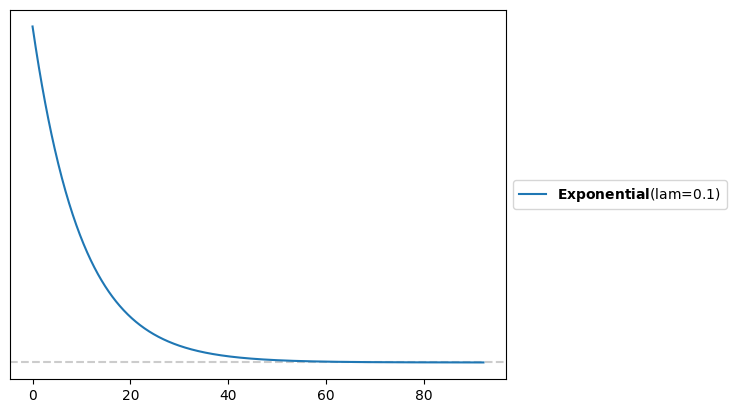

In [84]:
#heaviness of tails in Student-t
pz.Exponential(1/10).plot_pdf()

**Likelihood:**

In [90]:
with pm.Model() as model_mix:
    ω = pm.Dirichlet("ω", a = np.ones(2))
    μ = pm.Normal("μ", mu = [-5, 2], sigma = 5, shape = 2)
    σ = pm.HalfNormal("σ", sigma = 5, shape = 2)

    y = pm.Mixture("y", w = ω, comp_dists=[pm.Normal.dist(mu = μ[0], sigma = σ[0]), pm.Normal.dist(mu = μ[1], sigma = σ[1])], observed = data_cleaned)

    idata_mix = pm.sample(2000, tune = 1000)

Output()

The code above builds a Bayesian Gaussian mixture model in PyMC. Inside **with pm.Model() as model_mix:**, we define the model’s components.

**ω = pm.Dirichlet("ω", a=np.ones(2))** defines the mixture weights (probabilities of each component), with a Dirichlet prior giving equal initial weight to both. This one was quite tedious to provide a visual for, so I just decided not to.

**μ = pm.Normal("μ", mu=[-5, 2], sigma=5, shape=2)** defines the means of the two normal components, with priors centered at -5 and 2 and uncertainty of 5.

**σ = pm.HalfNormal("σ", sigma=5, shape=2)** defines the standard deviations of the components, constrained to be positive.

**y = pm.Mixture(...)** says the observed data (data_cleaned) comes from a mixture of these two normals, weighted by ω.

**idata_mix = pm.sample(2000, tune=1000)** runs MCMC sampling to estimate the posterior distribution of all parameters, tuning the sampler for the first 1000 steps and keeping 2000 samples.

**Final Model:**

In [95]:
pm.sample_posterior_predictive(idata_mix, model=model_mix, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

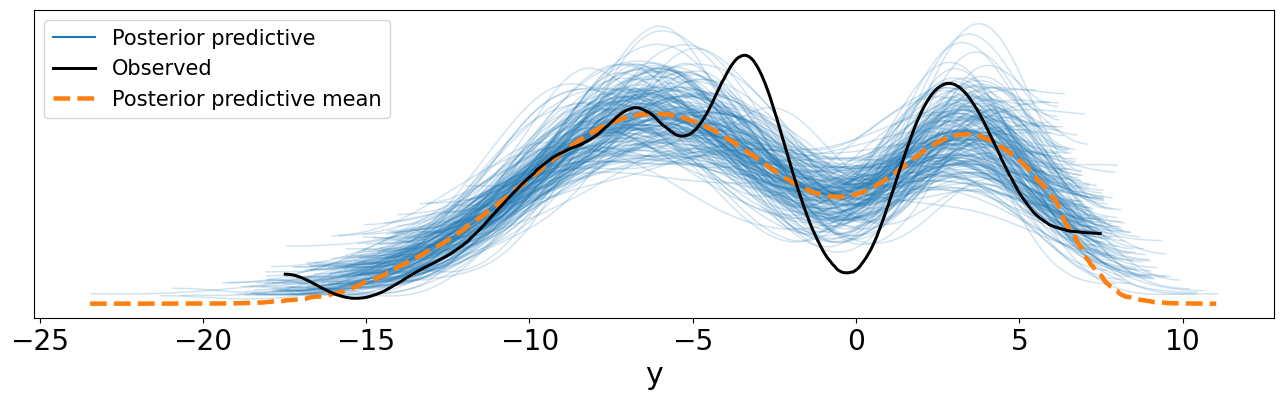

In [96]:
az.plot_ppc(idata_mix, num_pp_samples=200, figsize=(16,4))

There we go! Unfortunately, this model doesn't perfectly match our observed data. However, I already had to use a somewhat complicated model (compared to my previous model), so I'm deeming it good enough.

Because of the bimodal nature of this dataset, which can be seen in the histogram, the first model I created using the Normal distribution was pretty terrible. I then did some research (through my good friend ChatGPT) and transitioned to a **Bayesian Mixture Model**, which I did my best to explain in the text box after. I found that this updated model fits the observed data much better, as it accounts for the two "peaks" we can see in the histogram.